In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [6]:
# Custom normalization function
def custom_normalization(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image / 255.0
    image = (image - mean) / std
    return image

data_dir = r'D:\JupyterNote\002_Notebook\dataset_roti\train'
image_size = (224, 224)
batch_size = 32
num_folds = 5
num_epochs = 10

In [9]:
# Load filenames and labels
def load_dataset(directory):
    classes = sorted(os.listdir(directory))
    file_paths = []
    labels = []
    for label, class_dir in enumerate(classes):
        class_dir = os.path.join(directory, class_dir)
        for fname in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(str(label))  # Convert label to string
    return np.array(file_paths), np.array(labels), classes

# Load dataset
file_paths, labels, classes = load_dataset(data_dir)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
fold_no = 1
for train_index, val_index in kf.split(file_paths):
    print(f'Fold {fold_no}')

    # Split dataset into train and validation sets
    train_files, val_files = file_paths[train_index], file_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Data generators
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=custom_normalization
    )

    val_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)

    # Data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Model MobileNetV3
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(classes), activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    test_loss, test_accuracy = model.evaluate(val_generator)
    print(f"Fold {fold_no} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    fold_no += 1

Fold 1
Found 286 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.
Epoch 1/10


d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5097 - loss: 4.7723 - val_accuracy: 0.6389 - val_loss: 4.1531 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 993ms/step - accuracy: 0.5742 - loss: 4.0770 - val_accuracy: 0.6528 - val_loss: 3.6197 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6946 - loss: 3.5107 - val_accuracy: 0.7222 - val_loss: 3.1362 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7779 - loss: 3.0355 - val_accuracy: 0.7083 - val_loss: 2.7627 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7441 - loss: 2.6844 - val_accuracy: 0.6944 - val_loss: 2.4587 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 984ms/step - accuracy: 0.7451 - loss: 2.4340 - val_accuracy: 0.7222 - val_loss: 2.1761 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8006 - loss: 2.0678 - val_accur

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5189 - loss: 4.8737 - val_accuracy: 0.6806 - val_loss: 4.1601 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6045 - loss: 4.0826 - val_accuracy: 0.6806 - val_loss: 3.6314 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7331 - loss: 3.5177 - val_accuracy: 0.7222 - val_loss: 3.1672 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6737 - loss: 3.0969 - val_accuracy: 0.7083 - val_loss: 2.7840 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 995ms/step - accuracy: 0.7809 - loss: 2.6610 - val_accuracy: 0.7361 - val_loss: 2.4397 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7425 - loss: 2.3707 - val_accuracy: 0.7639 - val_loss: 2.1567 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7554 - loss: 2.1308 - val_accuracy

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5371 - loss: 4.8449 - val_accuracy: 0.6667 - val_loss: 4.1686 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6029 - loss: 4.0699 - val_accuracy: 0.6667 - val_loss: 3.6030 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7306 - loss: 3.5375 - val_accuracy: 0.7639 - val_loss: 3.1318 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7206 - loss: 3.0449 - val_accuracy: 0.7639 - val_loss: 2.7402 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7251 - loss: 2.6950 - val_accuracy: 0.7500 - val_loss: 2.4227 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7547 - loss: 2.3345 - val_accuracy: 0.7778 - val_loss: 2.1460 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7403 - loss: 2.0740 - val_accuracy: 0

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5602 - loss: 4.6588 - val_accuracy: 0.6901 - val_loss: 4.0895 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6556 - loss: 4.0477 - val_accuracy: 0.7183 - val_loss: 3.5497 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6603 - loss: 3.5129 - val_accuracy: 0.7606 - val_loss: 3.1037 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6843 - loss: 3.0958 - val_accuracy: 0.7746 - val_loss: 2.7154 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7072 - loss: 2.7010 - val_accuracy: 0.7465 - val_loss: 2.3863 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7522 - loss: 2.3429 - val_accuracy: 0.7465 - val_loss: 2.1139 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7191 - loss: 2.1178 - val_accuracy: 0

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5485 - loss: 4.6786 - val_accuracy: 0.6479 - val_loss: 4.1077 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5875 - loss: 4.0612 - val_accuracy: 0.7606 - val_loss: 3.5649 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6661 - loss: 3.5033 - val_accuracy: 0.7042 - val_loss: 3.1418 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7157 - loss: 3.0376 - val_accuracy: 0.7887 - val_loss: 2.7553 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7728 - loss: 2.6114 - val_accuracy: 0.7746 - val_loss: 2.4433 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7167 - loss: 2.3598 - val_accuracy: 0.7746 - val_loss: 2.1639 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7772 - loss: 2.0457 - val_accuracy: 0

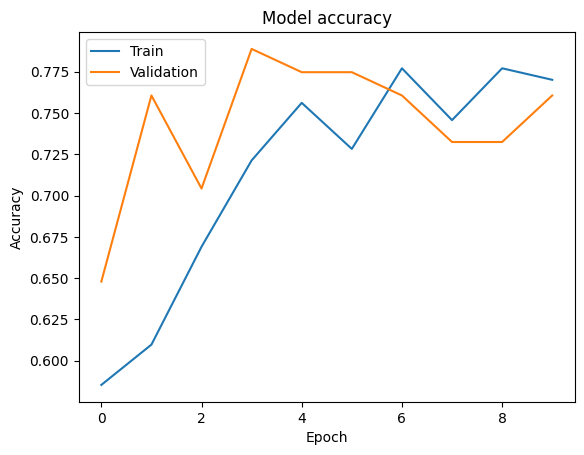

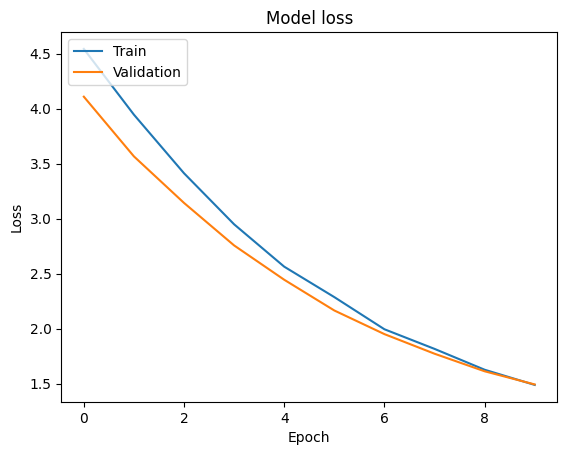

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
